In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess
import shutil
import time
import random
import pickle as pkl
from collections import defaultdict
import seaborn as sns
from nilearn import datasets, image
from nilearn.image import load_img, index_img
from nilearn.plotting import plot_epi
from nilearn.maskers import NiftiLabelsMasker
from nilearn.masking import apply_mask
import nibabel as nib
# from PyIF import te_compute as te
from joblib import delayed, Parallel
import pandas as pd
from scipy.stats import zscore
from scipy.optimize import curve_fit
from scipy.signal import convolve
from joblib import Parallel, delayed
import glob

from utils.data_loader import DataLoader
from utils.plotting import plot_voxels, plot_w_fit
# from utils.relaxation_time import RelaxationTime
from utils.timer import TimerController
# from spatial_correlations import linear_map, binarize_lm

# import seaborn as sns
import scienceplots

plt.style.use(['science','no-latex', 'ieee'])
plt.rcParams.update({
    "font.family": "DejaVu Sans",   # specify font family here
})

In [2]:
global tc
tc = TimerController()

In [1]:
def linear_map(signal, ignore_nans=True):
    if not type(signal) is np.ndarray:
        signal = np.array(signal)
    if ignore_nans:
        a, b = np.nanmax(signal), np.nanmin(signal)
    else:
        a, b = max(signal), min(signal)
    
    return (2*signal-(a+b))/(a - b)

def binarize(signal):
    arr_sorted = np.sort(arr)
    avg_max = np.mean(arr_sorted[-10:])
    avg_min = np.mean(arr_sorted[:10])
    cutoff = (avg_max + avg_min)/2
    signal[signal > cutoff] = 1
    signal[signal <= cutoff] = 0

In [4]:
def get_nan_masked_data(data):
    skr_data = np.empty_like(data)
    skr_data[:] = np.nan
    for i in range(sk_idx.shape[1]):
        x, y, z = sk_idx[0][i], sk_idx[1][i], sk_idx[2][i]
        skr_data[x, y, z, :] = data[x, y, z, :]
    return skr_data

In [5]:
def get_mask(sk_idx, data_shape):
    mask = np.zeros(shape=data_shape)
    for i in range(sk_idx.shape[1]):
        x, y, z = sk_idx[0][i], sk_idx[1][i], sk_idx[2][i]
        mask[x, y, z] = 1
    return mask

## Union Find

In [6]:
class UnionFind:
    def __init__(self, arr_shape):
        n = arr_shape[0]*arr_shape[1]*arr_shape[2]
        self.parent = [i for i in range(n)]
        self.size = [1] * n
        self.arr_shape = arr_shape

    def ravel_index(self, idxs):
        return np.ravel_multi_index(idxs, self.arr_shape)
        
    def unravel_index(self, idx):
        return np.unravel_index(idx, self.arr_shape)
        
    def find(self, i):
        while i != self.parent[i]:
            self.parent[i] = self.parent[self.parent[i]]
            i = self.parent[i]
        return i

    def union(self, i, j):
        root_i = self.find(i)
        root_j = self.find(j)
        if root_i == root_j:
            return
        if self.size[root_i] < self.size[root_j]:
            self.parent[root_i] = root_j
            self.size[root_j] += self.size[root_i]
        else:
            self.parent[root_j] = root_i
            self.size[root_i] += self.size[root_j]

    def connected(self, i, j):
        return self.find(i) == self.find(j)

In [7]:
def get_clusters(bin_data, mask, t=50):
    arr_shape = bin_data.shape[:-1]
    uf = UnionFind(arr_shape)
    for x in range(mask.shape[0]):
        for y in range(mask.shape[1]):
            for z in range(mask.shape[2]):
                if mask[x, y, z] == 0:
                    uf.parent[uf.ravel_index([x, y, z])] = np.nan

    for x in range(arr_shape[0]):
        for y in range(arr_shape[1]):
            for z in range(arr_shape[2]):
                if mask[x, y, z]:

                    pt = bin_data[x, y, z, t]
                    idx = uf.ravel_index([x, y, z])
                    left, above, behind = None, None, None
                    lidx, aidx, bidx = None, None, None

                    if (x-1 > 0) and (mask[x-1, y, z]): 
                        left = bin_data[x-1, y, z, t]
                        lidx = uf.ravel_index([x-1, y, z])
                    if (y-1 > 0) and (mask[x, y-1, z]): 
                        above = bin_data[x, y-1, z, t]
                        aidx = uf.ravel_index([x, y-1, z])
                    if (z-1 > 0) and (mask[x, y, z-1]): 
                        behind = bin_data[x, y, z-1, t]
                        bidx = uf.ravel_index([x, y, z-1])

                    if (left != pt) and (above != pt) and (behind != pt):
                        # Retain label
                        pass
                    elif (left == pt) and (above != pt) and (behind != pt): 
                        # Join left and current
                        uf.union(idx, lidx)
                    elif (left != pt) and (above == pt) and (behind != pt): 
                        # Join above and current
                        uf.union(idx, aidx)
                    elif (left != pt) and (above != pt) and (behind == pt): 
                        # Join behind and current
                        uf.union(idx, bidx)
                    elif (left == pt) and (above == pt) and (behind != pt):
                        # Join current, left, above
                        uf.union(idx, lidx)
                        uf.union(idx, aidx)
                    elif (left == pt) and (above != pt) and (behind == pt): 
                        # Join current, left, behind
                        uf.union(idx, lidx)
                        uf.union(idx, bidx)
                    elif (left != pt) and (above == pt) and (behind == pt): 
                        # Join current, above, behind
                        uf.union(idx, aidx)
                        uf.union(idx, bidx)
                    elif (left == pt) and (above == pt) and (behind == pt): 
                        # Join all
                        uf.union(idx, lidx)
                        uf.union(idx, aidx)
                        uf.union(idx, bidx)
    uf.parent = np.array(uf.parent)
    return uf

In [8]:
def get_saved_fp(sub, t):
    return os.path.join(CLUSTERS_SAVE_DIR, sub, f'clusters-{t}.pkl')

In [9]:
def get_t_clusters(bin_data, mask, save=False):
    t_clusters = []
    print("t = ", flush=True)
    for t in range(bin_data.shape[-1]):
        print(t, end=" ", flush=True)
        clusters_uf = get_clusters(bin_data, mask, t=t)
        t_clusters.append(clusters_uf.parent)
    if save:
#         save_fp = get_saved_fp(sub, "all")
#         np.save(save_fp, t_clusters)
        print(f"Saving to {save}")
        with open(save, 'wb') as f:
            pkl.dump(t_clusters, f)
    print()
    return np.array(t_clusters)

In [10]:
def process_subject(sub):
    print(f"On sub {sub}", flush=True)
    tc.start_timer(sub)
    
    sub_save_fp = get_saved_fp(sub, "all")
    if os.path.exists(sub_save_fp): 
        print(f"Skipping subject {sub}")
        return None, None
    
    
    sub_save_dir = os.path.join(CLUSTERS_SAVE_DIR, sub)
    if not os.path.exists(sub_save_dir): os.makedirs(sub_save_dir)
    
    data = dloader.get_func(sub).get_fdata()
    skr_data = get_nan_masked_data(data)
#     lm_data = linear_map(skr_data)
    lm_data = np.apply_along_axis(linear_map, 3, skr_data)
    bin_data = binarize(lm_data)

    mask = get_mask(sk_idx, data.shape[:-1])
    t_clusters = get_t_clusters(bin_data, mask, save=sub_save_fp)
    
    print(f"Finished {sub} in {tc.get_elapsed_time(sub)} s")
#     n_clusters = []
#     for cluster in t_clusters:
#         n_clusters.append(len(set(cluster[~np.isnan(cluster)])))
    
    return None, t_clusters

In [ ]:
if __name__ == "__main__":
    root_dir = '/scratch/anirudh.palutla/adni/preproc'
    CLUSTERS_SAVE_DIR = '/scratch/anirudh.palutla/clusters'

    dloader = DataLoader(root_dir)
    subjects_list = dloader.subjects_list
    sk_idx = np.load('skull_indices.npy')

#     for sub_idx in range(0, len(dloader.subjects_list)):
# #     sub_idx = 40
#         sub = dloader.subjects_list[sub_idx]
        
#         n_clusters, t_clusters = process_subject(sub)
#     print("Starting jobs")
#     results = Parallel(n_jobs=10)(
#         delayed(process_subject)(sub) for sub in dloader.subjects_list[:10])

In [12]:
# sub_n_clusters_save_fp = os.path.join(CLUSTERS_SAVE_DIR, 'sub_n_clusters.pkl')
# with open(sub_n_clusters_save_fp, 'wb') as f:
#     pkl.dump(sub_n_clusters, f)

In [12]:
def load_t_clusters(sub_idx):
    with open(get_saved_fp(dloader.subjects_list[sub_idx], "all"), 'rb') as f:
        t_clusters = np.array(pkl.load(f))
    return t_clusters

In [13]:
def get_n_clusters(t_clusters):
    n_clusts = []
    for t in range(t_clusters.shape[0]):
        clusts = t_clusters[t]
        n_clusts.append(len(set(clusts[~np.isnan(clusts)])))
    return n_clusts

In [14]:
def count_occurrences(arr):
    count_dict = defaultdict(int)
    for elem in arr:
        count_dict[elem] += 1
    return count_dict

def get_cluster_sizes(t_clusters):
    cluster_sizes = []
    for t in range(t_clusters.shape[0]):
        clusts = t_clusters[t]
        sizes = count_occurrences(clusts[~np.isnan(clusts)])
        cluster_sizes.append(list(sizes.values()))
    return cluster_sizes

### Temp start


In [134]:
sub_idx = 10
ff = dloader.get_func(sub_idx).get_fdata()

In [135]:
data = ff
skr_data = get_nan_masked_data(data)
lm_data = np.apply_along_axis(linear_map, 3, skr_data)
bin_data = binarize(lm_data)

/tmp/ipykernel_11591/338795709.py:5: RuntimeWarning: All-NaN slice encountered
  a, b = np.nanmax(signal), np.nanmin(signal)


In [136]:
arr_shape = bin_data.shape[:-1]
uf = UnionFind(arr_shape)

In [138]:
t_clusters = load_t_clusters(sub_idx)
r_t_clusters = t_clusters.reshape((bin_data.shape[-1], 51, 67, 67))

In [139]:
def convert_labels_to_cont(arr):
    og_shape = arr.shape
    cvs = {}
    cnt = 0
    cont_labels = []
    for i in arr.flatten():
        if np.isnan(i):
            cont_labels.append(np.nan)
            continue
        if cvs.get(i, False):
            cont_labels.append(cvs[i])
        else:    
            cnt += 1
            cvs[i] = cnt
            cont_labels.append(cvs[i])
    cont_labels = np.array(cont_labels).reshape(og_shape)
    print(cnt)
    return cont_labels

In [140]:
t = 70
clabels = convert_labels_to_cont(r_t_clusters)
clabels.shape

14512


(200, 51, 67, 67)

<Axes: >

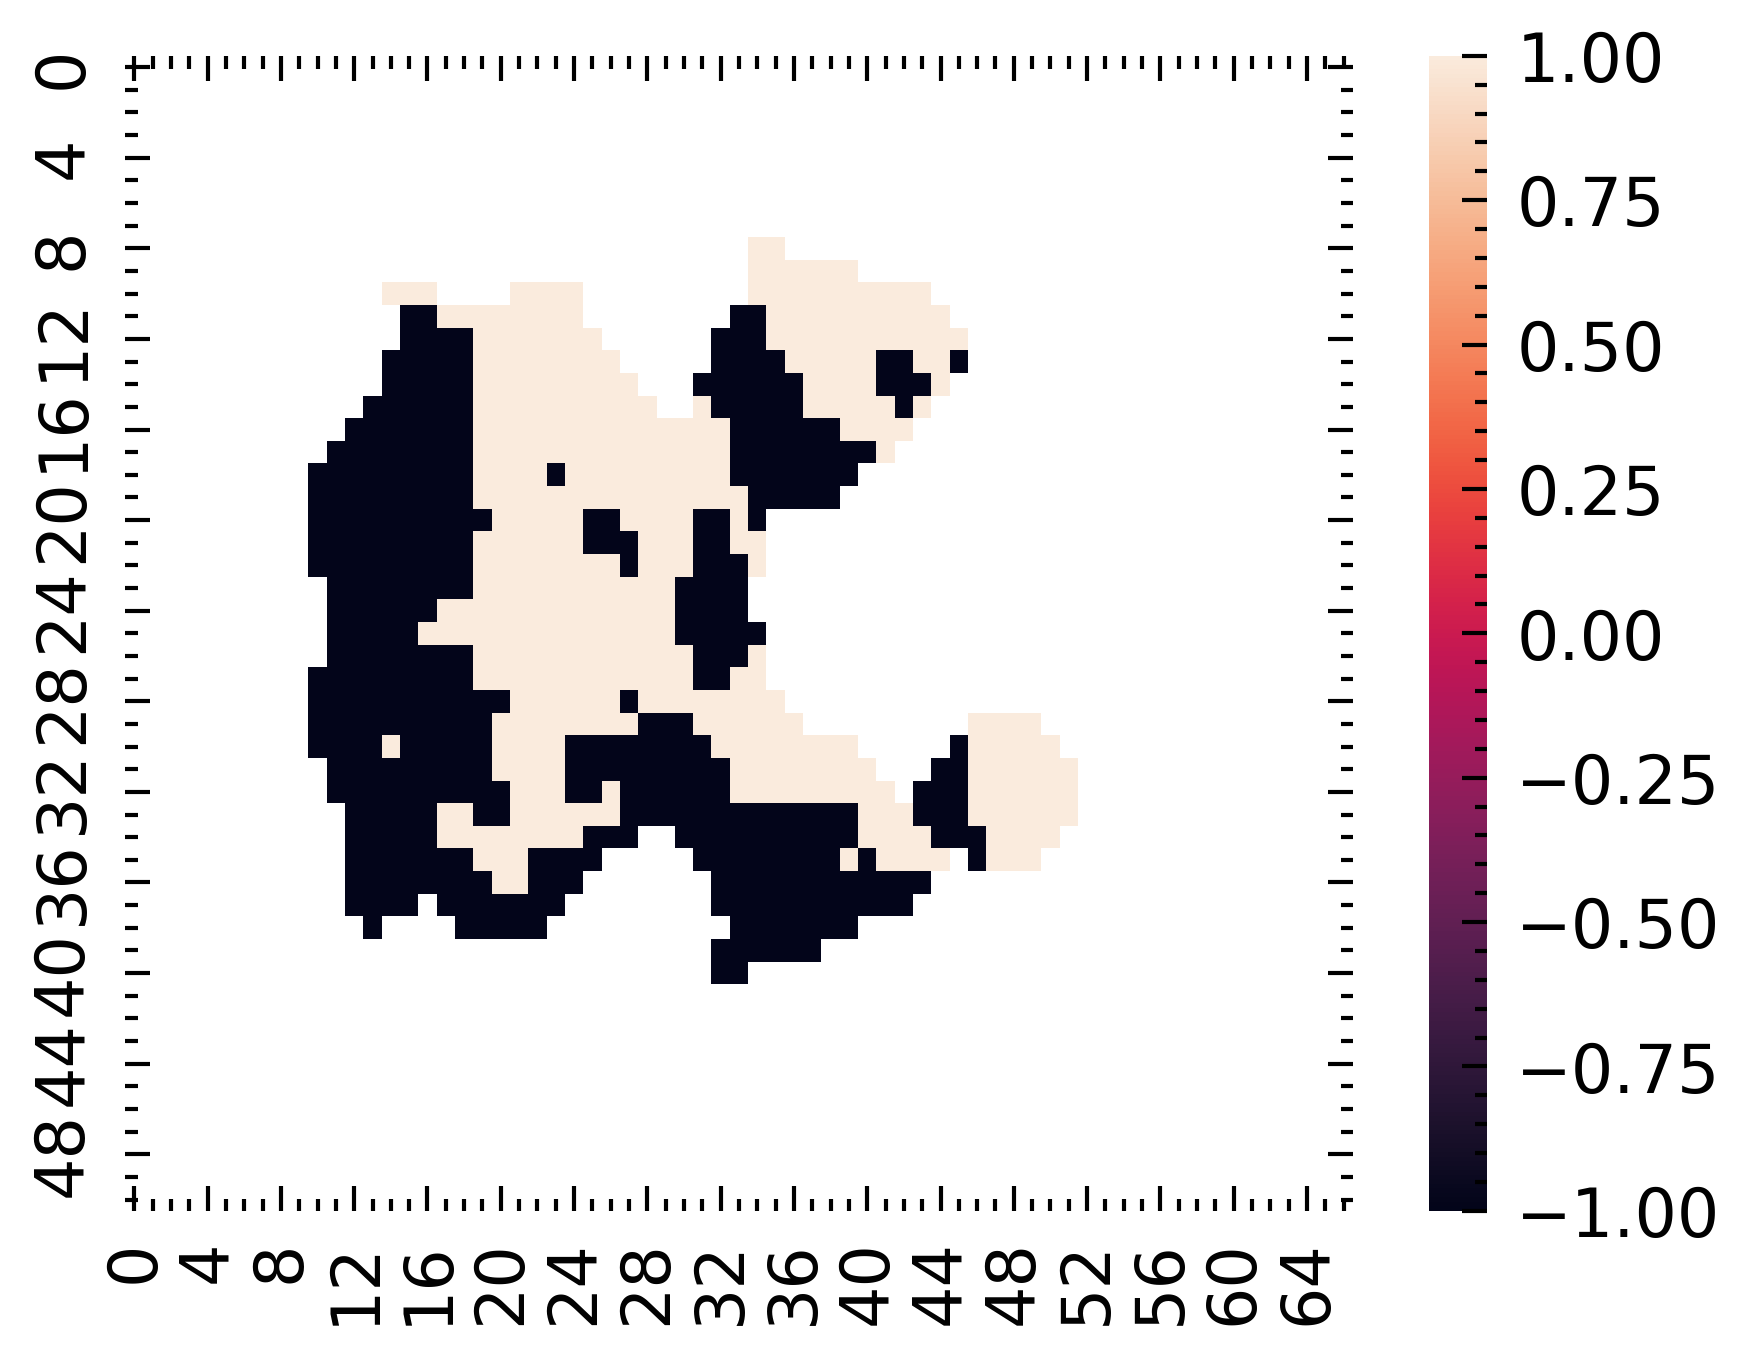

In [143]:
y = 30
z = 30
sns.heatmap(bin_data[:, :, z, t])
# plt.xlim(28, 44)

12


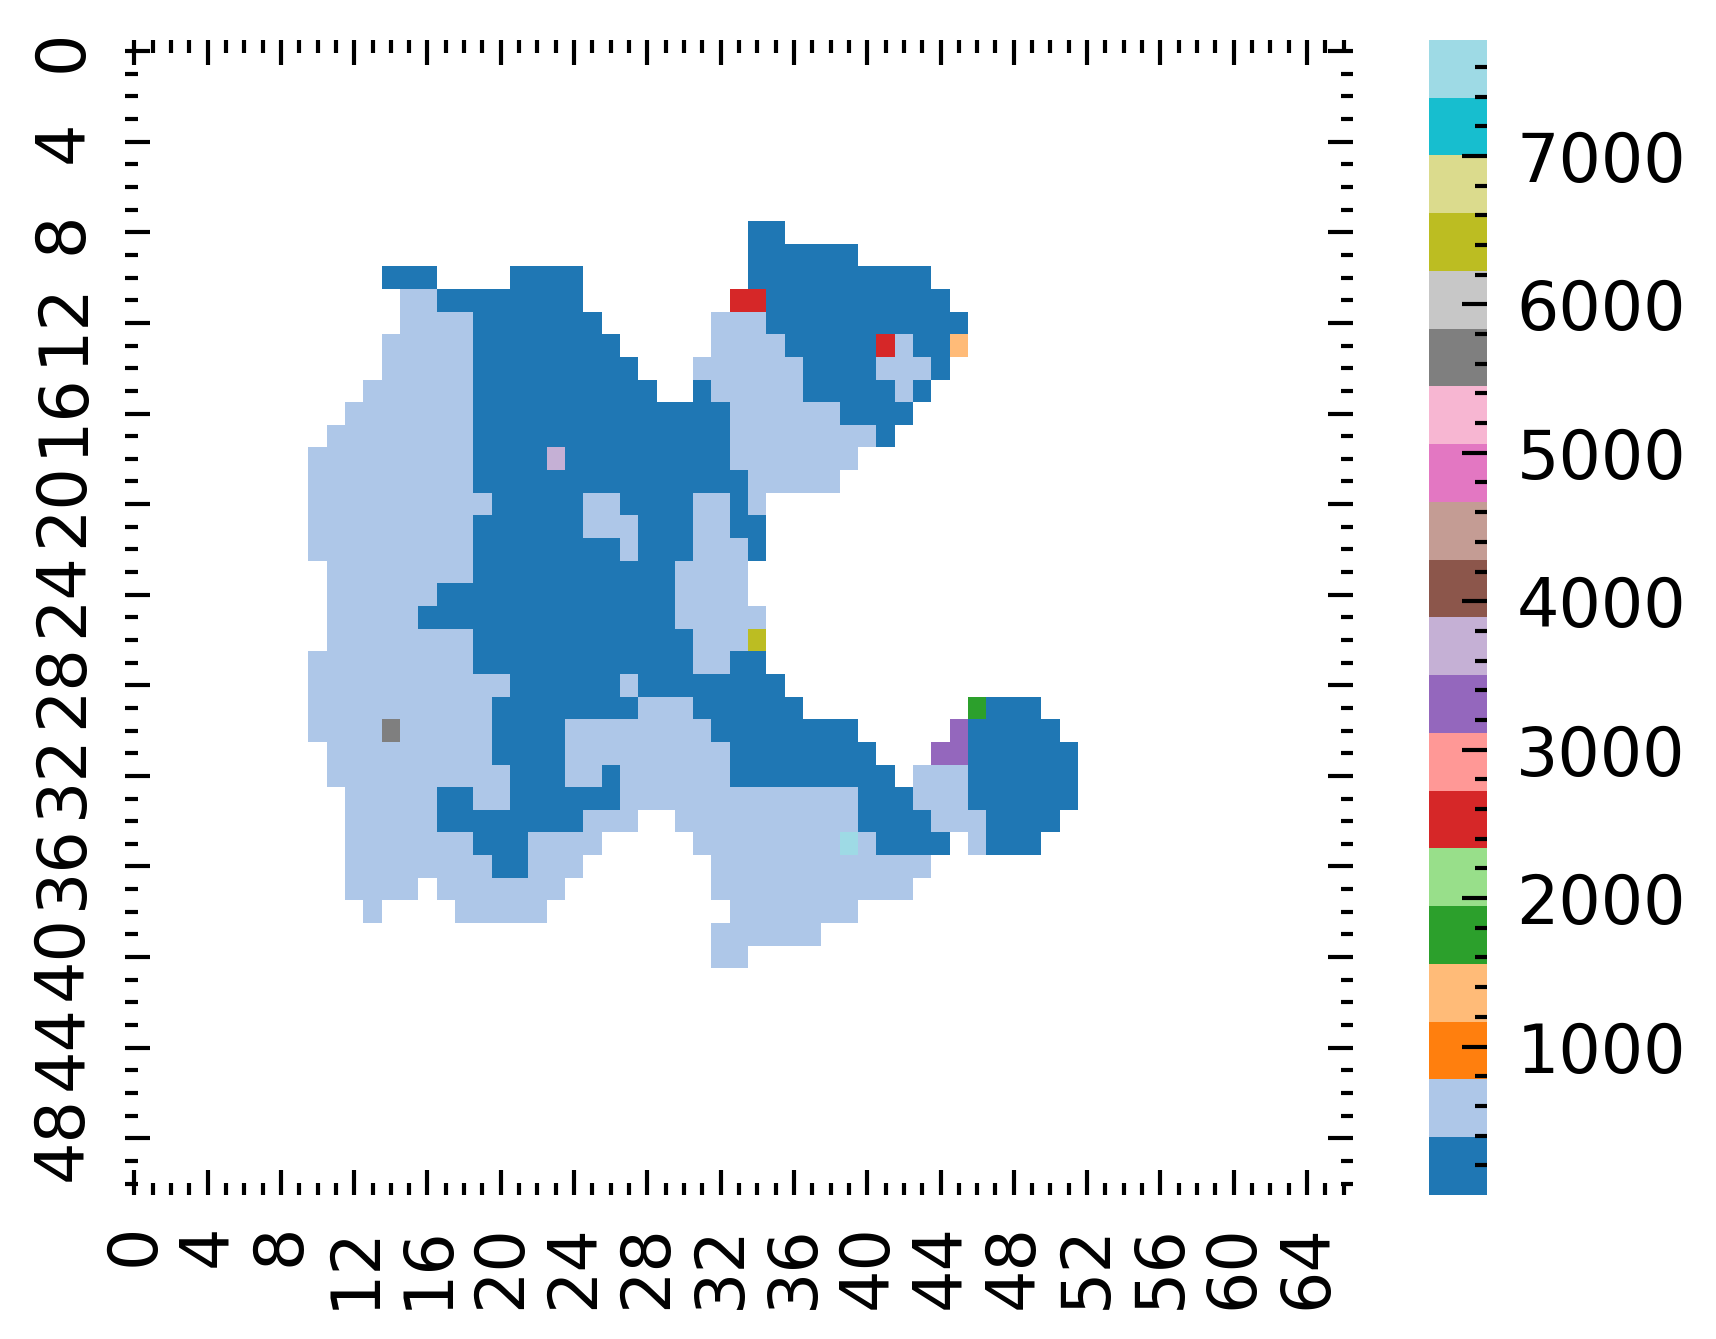

In [145]:
to_plot = clabels[t, :, :, z]
sns.heatmap(to_plot, cmap='tab20')
print(len(set(to_plot[~np.isnan(to_plot)])))
# plt.xlim(28, 44)

### Temp end

In [15]:
cluster_sizes = []
for i in range(len(dloader.subjects_list)):
    t_clusters = load_t_clusters(i)
    print(f"On sub {i}")
    sub_cluster_sizes = get_cluster_sizes(t_clusters)
    cluster_sizes.append(sub_cluster_sizes)
    
#     c = 'red' if dloader.diag[i] else 'blue'
#     plt.hist(n_clusts, density=True, bins=30, label=dloader.diag[i], color=c, alpha=0.5)
# plt.xlabel("$n_{clusters}$")
# plt.ylabel("$P(n_{clusters})$")
# plt.legend()

On sub 0
On sub 1
On sub 2
On sub 3
On sub 4
On sub 5
On sub 6
On sub 7
On sub 8
On sub 9
On sub 10
On sub 11
On sub 12
On sub 13
On sub 14
On sub 15
On sub 16
On sub 17
On sub 18
On sub 19
On sub 20
On sub 21
On sub 22
On sub 23
On sub 24
On sub 25
On sub 26
On sub 27
On sub 28
On sub 29
On sub 30
On sub 31
On sub 32
On sub 33
On sub 34
On sub 35
On sub 36
On sub 37
On sub 38
On sub 39
On sub 40
On sub 41
On sub 42
On sub 43
On sub 44
On sub 45
On sub 46
On sub 47
On sub 48
On sub 49
On sub 50
On sub 51
On sub 52
On sub 53
On sub 54
On sub 55
On sub 56
On sub 57
On sub 58
On sub 59
On sub 60
On sub 61
On sub 62
On sub 63
On sub 64
On sub 65
On sub 66
On sub 67
On sub 68
On sub 69
On sub 70
On sub 71
On sub 72
On sub 73
On sub 74
On sub 75
On sub 76
On sub 77
On sub 78
On sub 79
On sub 80
On sub 81
On sub 82
On sub 83
On sub 84
On sub 85
On sub 86
On sub 87
On sub 88


In [16]:
ad_t_clusts = []
cn_t_clusts = []

for t in range(140):
    sub_ad_t_clusts, sub_cn_t_clusts = [], []
    for sub_idx in range(len(dloader.subjects_list)):
        if dloader.diag[sub_idx] == 1:
            for x in cluster_sizes[sub_idx][t]: sub_ad_t_clusts.append(x)
        else:
            for x in cluster_sizes[sub_idx][t]: sub_cn_t_clusts.append(x)
            
    ad_t_clusts.append(sub_ad_t_clusts)
    cn_t_clusts.append(sub_cn_t_clusts)
    

In [17]:
def get_contrasting_colors(n_shades):
#     def generate_shades(n_shades=140):
    shades_blue = plt.cm.Blues(np.linspace(0.3, 1, n_shades))
    shades_orange = plt.cm.Oranges(np.linspace(0.3, 1, n_shades))
    return shades_blue, shades_orange

c1, c2 = get_contrasting_colors(len(ad_t_clusts))

In [18]:
ad_data = np.array(ad_t_clusts[t])
len(ad_data[ad_data < 10])

9786

AD:  101 28023 5052.7892156862745 7670.68219092653
CN:  101 26150 5159.151702786377 7522.436653099612


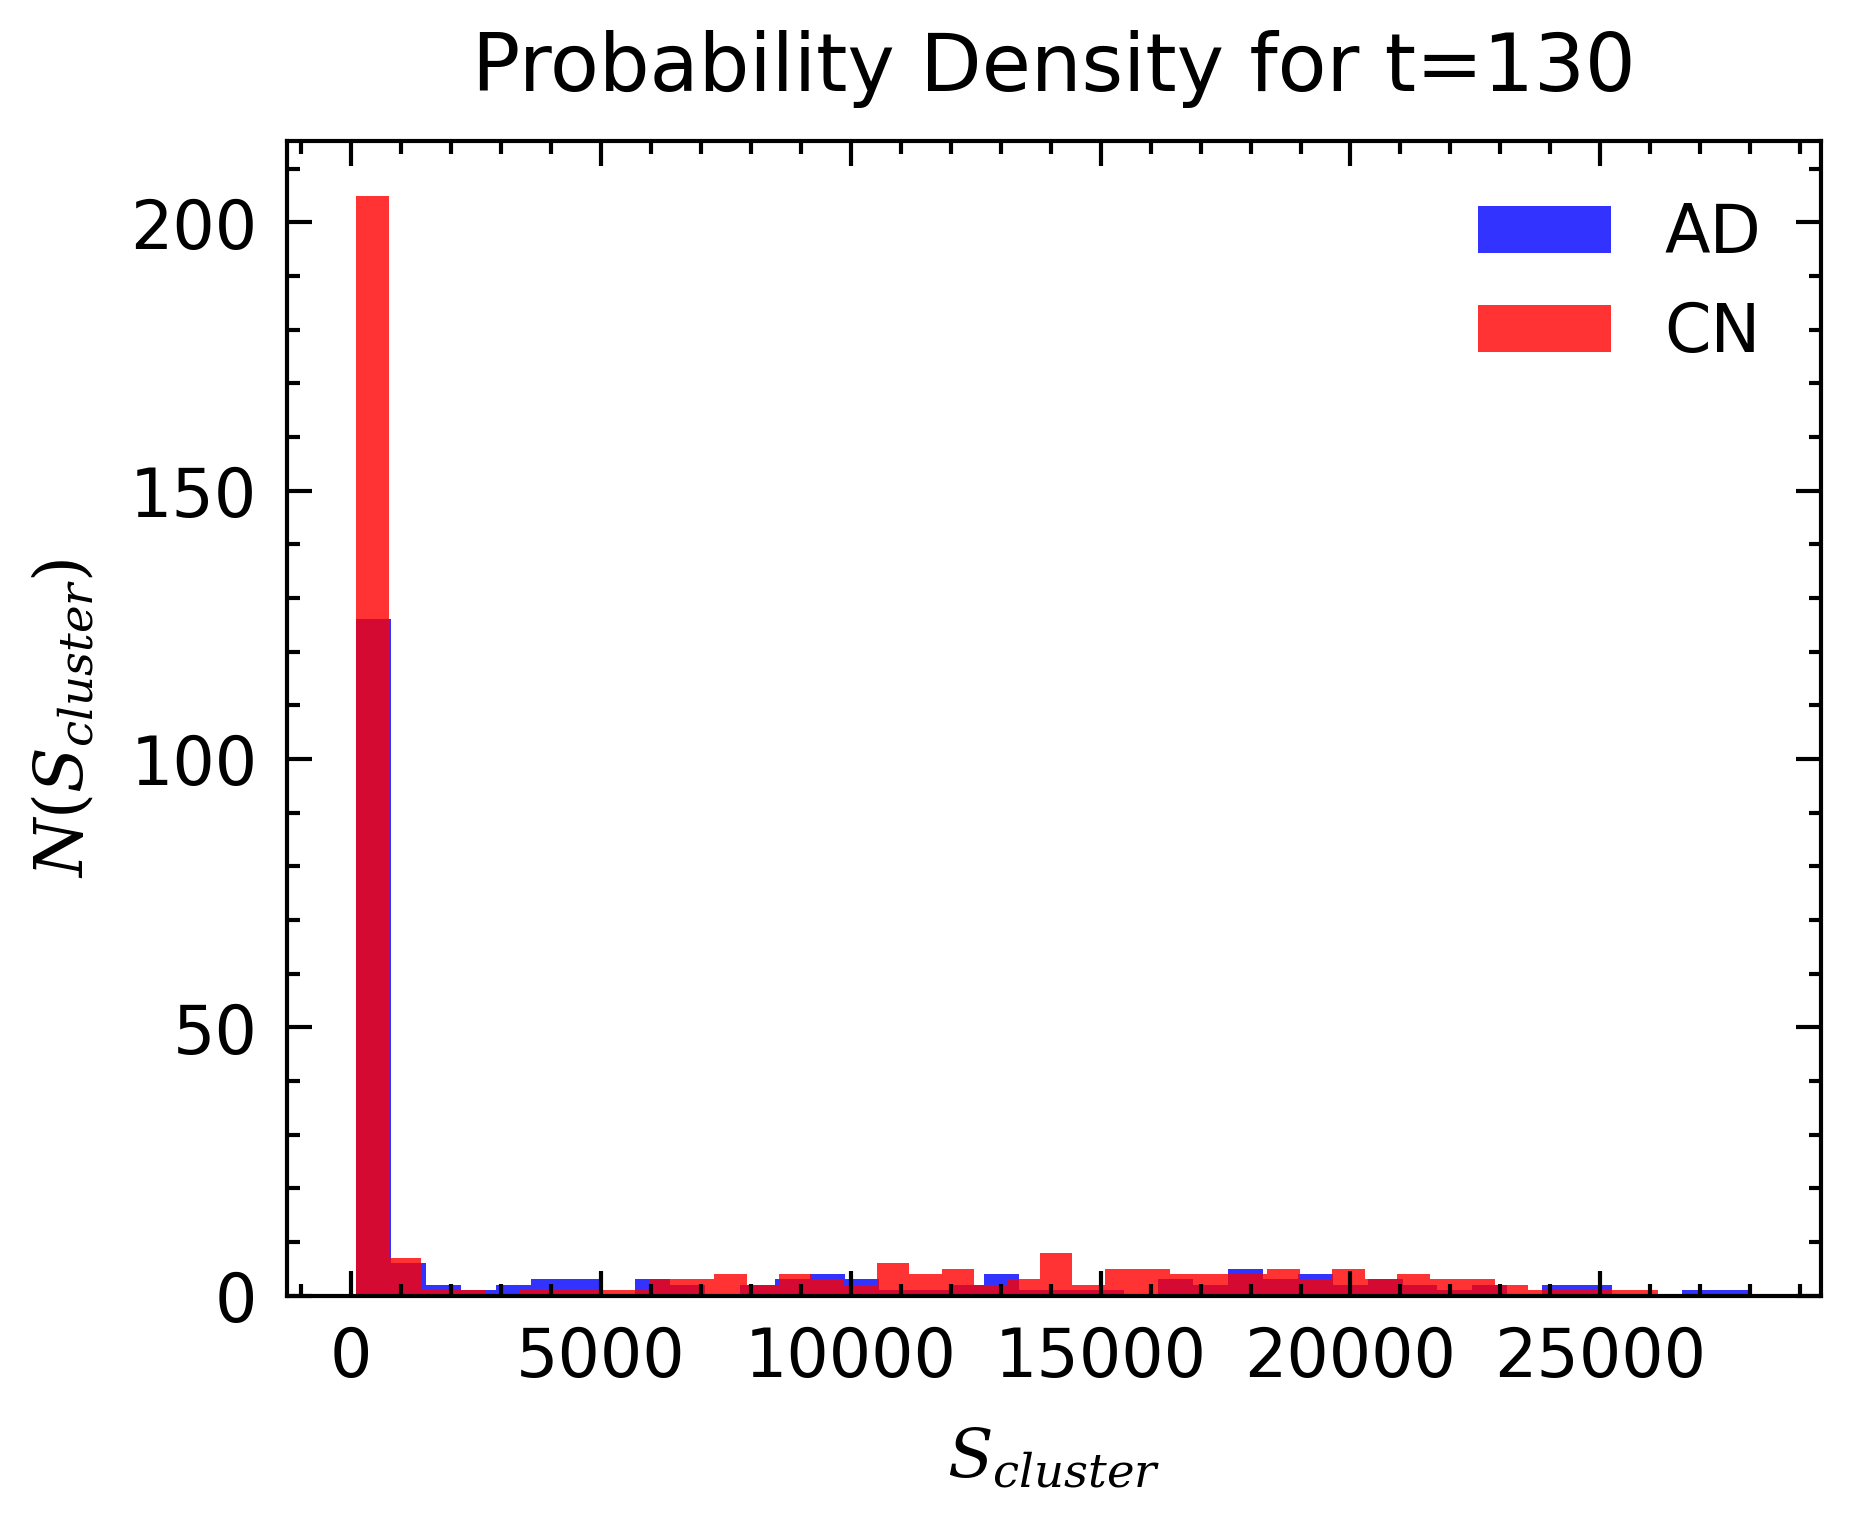

In [19]:
t = 130
ad_data = np.array(ad_t_clusts[t])
cn_data = np.array(cn_t_clusts[t])

data_min, data_max = 100, np.inf
ad_data = ad_data[ad_data > data_min]
ad_data = ad_data[ad_data < data_max]
cn_data = cn_data[cn_data > data_min]
cn_data = cn_data[cn_data < data_max]

plt.hist(ad_data, label='AD', color='blue', alpha=0.8, bins=40)
plt.hist(cn_data, label='CN', color='red', alpha=0.8, bins=40)
print("AD: ", np.min(ad_data), np.max(ad_data), np.mean(ad_data), np.std(ad_data))
print("CN: ", np.min(cn_data), np.max(cn_data), np.mean(cn_data), np.std(cn_data))

plt.xlabel("$S_{cluster}$")
plt.ylabel("$N(S_{cluster})$")
plt.title(f"Probability Density for t={t}")
# plt.xlim(data_min, plt.get_xlim()[-1])
plt.legend()
# plt.xlim(0, np.mean(ad_data) + 2*np.std(ad_data))

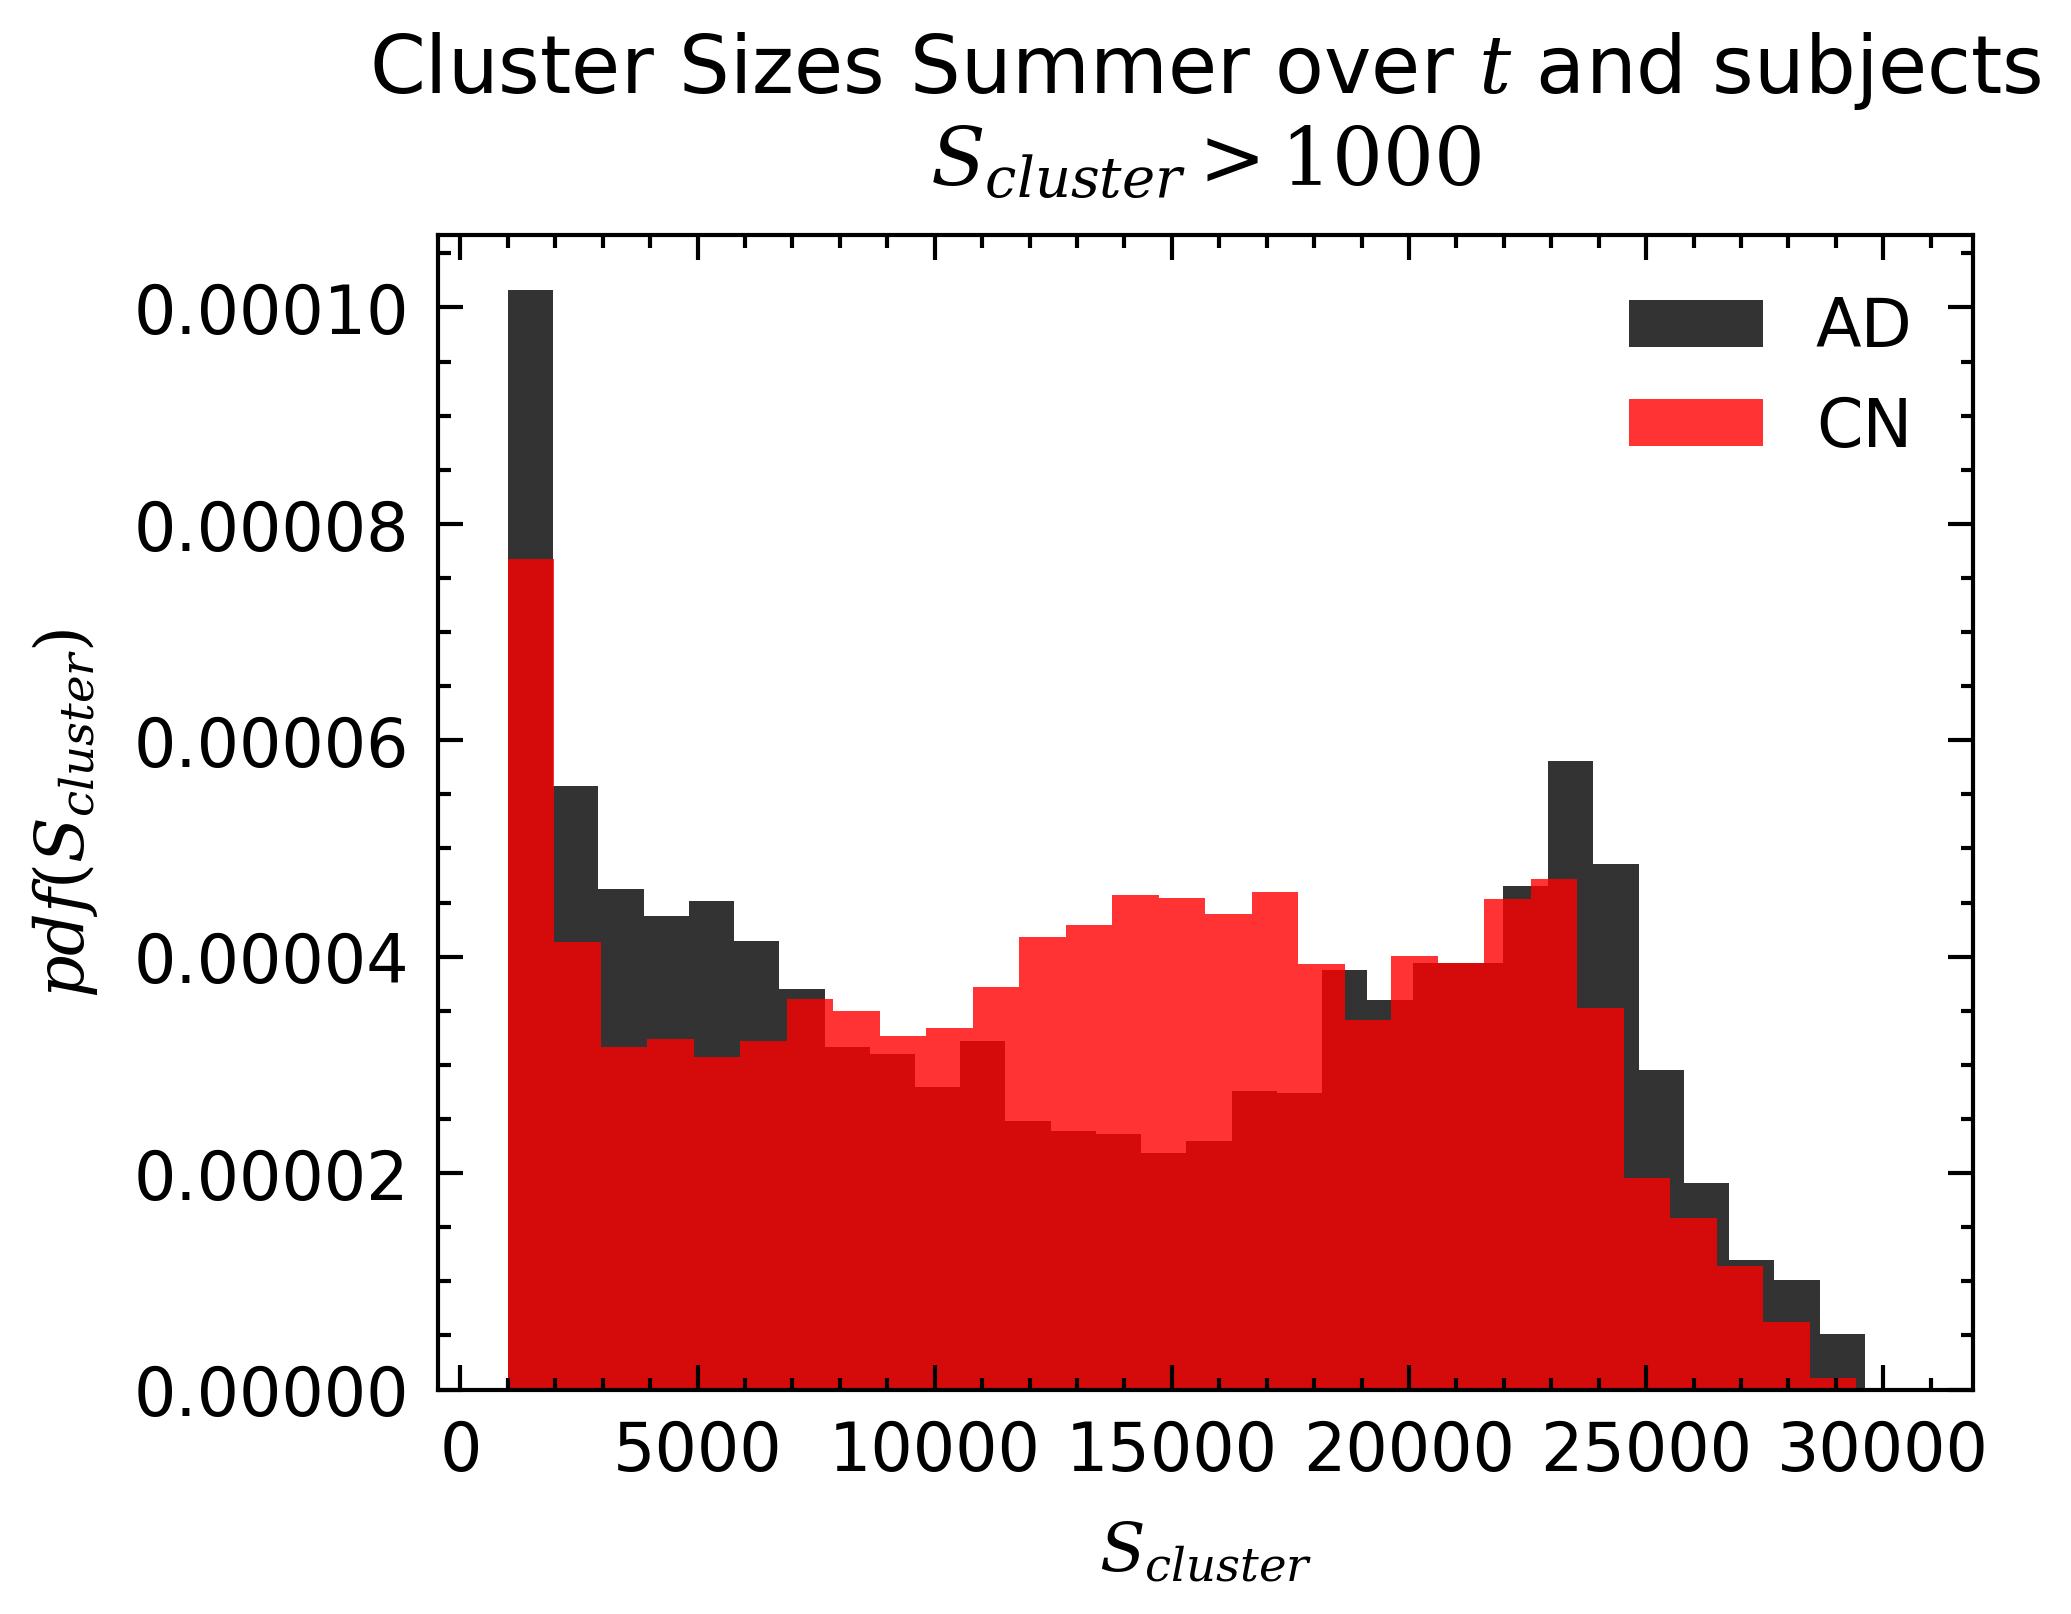

In [103]:
ad_avg_t_clusts = []
cn_avg_t_clusts = []

data_min, data_max = 1000, np.inf
for t in range(len(ad_t_clusts)):
    ad_data = np.array(ad_t_clusts[t])
    cn_data = np.array(cn_t_clusts[t])
    
    ad_data = ad_data[ad_data > data_min]
    ad_data = ad_data[ad_data < data_max]
    cn_data = cn_data[cn_data > data_min]
    cn_data = cn_data[cn_data < data_max]
    
    for i in ad_data: ad_avg_t_clusts.append(i)
    for i in cn_data: cn_avg_t_clusts.append(i)

#     plt.hist(ad_data, color=c1[t], density=True, alpha=0.4, bins=40)
#     plt.hist(cn_data, color=c2[t], density=True, alpha=0.4, bins=40)
#     print("AD: ", np.min(ad_data), np.max(ad_data), np.mean(ad_data), np.std(ad_data))
#     print("CN: ", np.min(cn_data), np.max(cn_data), np.mean(cn_data), np.std(cn_data))

plt.hist(ad_avg_t_clusts, label='AD', alpha=0.8, bins=30, density=True)
plt.hist(cn_avg_t_clusts, label='CN', alpha=0.8, bins=30, density=True)
plt.xlabel("$S_{cluster}$")
plt.ylabel("$pdf(S_{cluster})$")
plt.title("Cluster Sizes Summer over $t$ and subjects\n$S_{cluster} >" +f"{data_min}$")
plt.legend()
# plt.xlim(5000, 30000)

In [110]:
ad_avg_n_clusts = []
cn_avg_n_clusts = []

data_min, data_max = 1500, np.inf
for sub_idx in range(len(dloader.subjects_list)):
    sub_n_clusts = []
    for t in range(len(ad_t_clusts)):
#         ad_data = np.array(ad_t_clusts[t])
#         cn_data = np.array(cn_t_clusts[t])

        sub_data = np.array(cluster_sizes[sub_idx][t])
        sub_data = sub_data[sub_data > data_min]
        sub_data = sub_data[sub_data < data_max]

        sub_n_clusts.append(len(sub_data))
    if dloader.diag[sub_idx] == 1:
        ad_avg_n_clusts.append(sub_n_clusts)
    else:
        cn_avg_n_clusts.append(sub_n_clusts)

ad_avg_n_clusts = np.array(ad_avg_n_clusts)        
cn_avg_n_clusts = np.array(cn_avg_n_clusts)
print(ad_avg_n_clusts.shape, cn_avg_n_clusts.shape)

(34, 140) (55, 140)


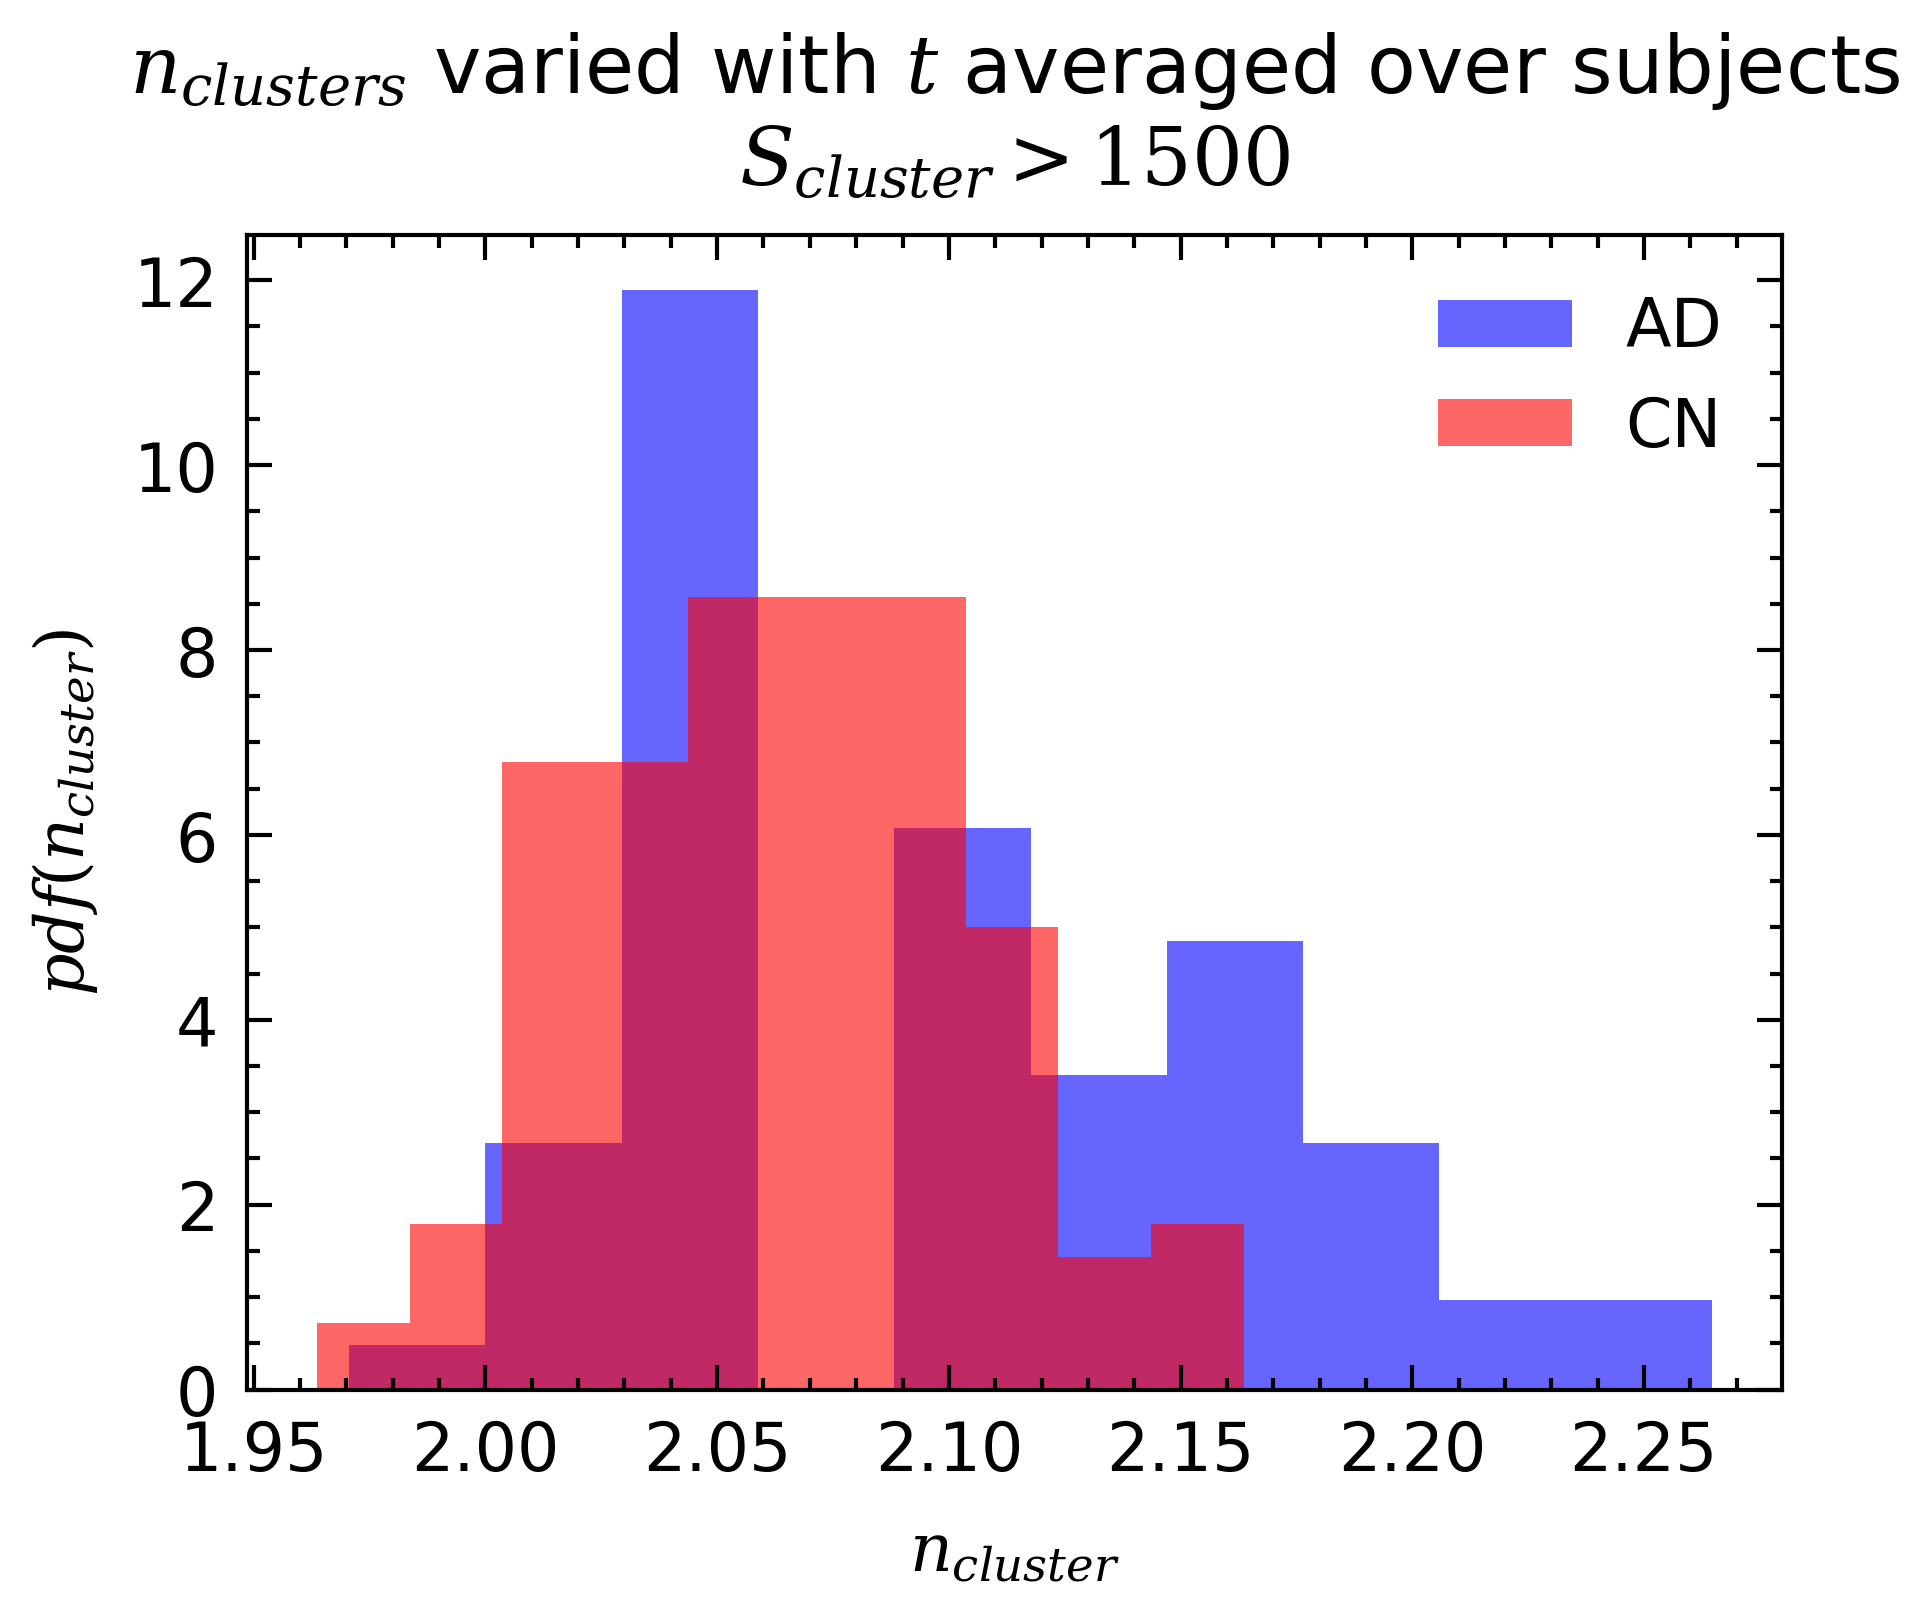

In [111]:
plt.hist(np.mean(ad_avg_n_clusts, axis=0), label='AD', color='blue', alpha=0.6, bins=10, density=True)
plt.hist(np.mean(cn_avg_n_clusts, axis=0), label='CN', color='red', alpha=0.6, bins=10, density=True)
plt.xlabel("$n_{cluster}$")
plt.ylabel("$pdf(n_{cluster})$")
plt.title("$n_{clusters}$ varied with $t$ averaged over subjects\n$S_{cluster} >" +f"{data_min}$")
plt.legend()
# plt.xlim(5000, 30000)

In [21]:
import colorsys

def generate_distinguishable_colors(n):
    hue_step = 1.0 / n
    saturation = 0.8
    lightness = 0.6

    colors = []

    for i in range(n):
        hue = i * hue_step
        r, g, b = colorsys.hls_to_rgb(hue, lightness, saturation)
        colors.append((r, g, b))

    return colors

colors_array = generate_distinguishable_colors(89)

In [33]:
ad_n_clusts = []
cn_n_clusts = []
for i in range(len(dloader.subjects_list)):
    t_clusters = load_t_clusters(i)
    n_clusts = get_n_clusters(t_clusters)
    print(f"On sub {i}")
    if dloader.diag[i] == 1:
        for n_clust in n_clusts:
            ad_n_clusts.append(n_clust)
    else:
        for n_clust in n_clusts:
            cn_n_clusts.append(n_clust)
    
#     c = 'red' if dloader.diag[i] else 'blue'
#     plt.hist(n_clusts, density=True, bins=30, alpha=0.5, color=colors_array[i])
#     plt.hist(n_clusts, density=True, bins=30, label=dloader.diag[i], color=c, alpha=0.5)


On sub 0
On sub 1
On sub 2
On sub 3
On sub 4
On sub 5
On sub 6
On sub 7
On sub 8
On sub 9
On sub 10
On sub 11
On sub 12
On sub 13
On sub 14
On sub 15
On sub 16
On sub 17
On sub 18
On sub 19
On sub 20
On sub 21
On sub 22
On sub 23
On sub 24
On sub 25
On sub 26
On sub 27
On sub 28
On sub 29
On sub 30
On sub 31
On sub 32
On sub 33
On sub 34
On sub 35
On sub 36
On sub 37
On sub 38
On sub 39
On sub 40
On sub 41
On sub 42
On sub 43
On sub 44
On sub 45
On sub 46
On sub 47
On sub 48
On sub 49
On sub 50
On sub 51
On sub 52
On sub 53
On sub 54
On sub 55
On sub 56
On sub 57
On sub 58
On sub 59
On sub 60
On sub 61
On sub 62
On sub 63
On sub 64
On sub 65
On sub 66
On sub 67
On sub 68
On sub 69
On sub 70
On sub 71
On sub 72
On sub 73
On sub 74
On sub 75
On sub 76
On sub 77
On sub 78
On sub 79
On sub 80
On sub 81
On sub 82
On sub 83
On sub 84
On sub 85
On sub 86
On sub 87
On sub 88


In [40]:
print("AD mean: ", np.mean(ad_n_clusts), " std: ", np.std(ad_n_clusts))
print("CN mean: ", np.mean(cn_n_clusts), " std: ", np.std(cn_n_clusts))

AD mean:  334.19595141700404  std:  54.15767264087501
CN mean:  335.24356223175965  std:  49.741839015901846


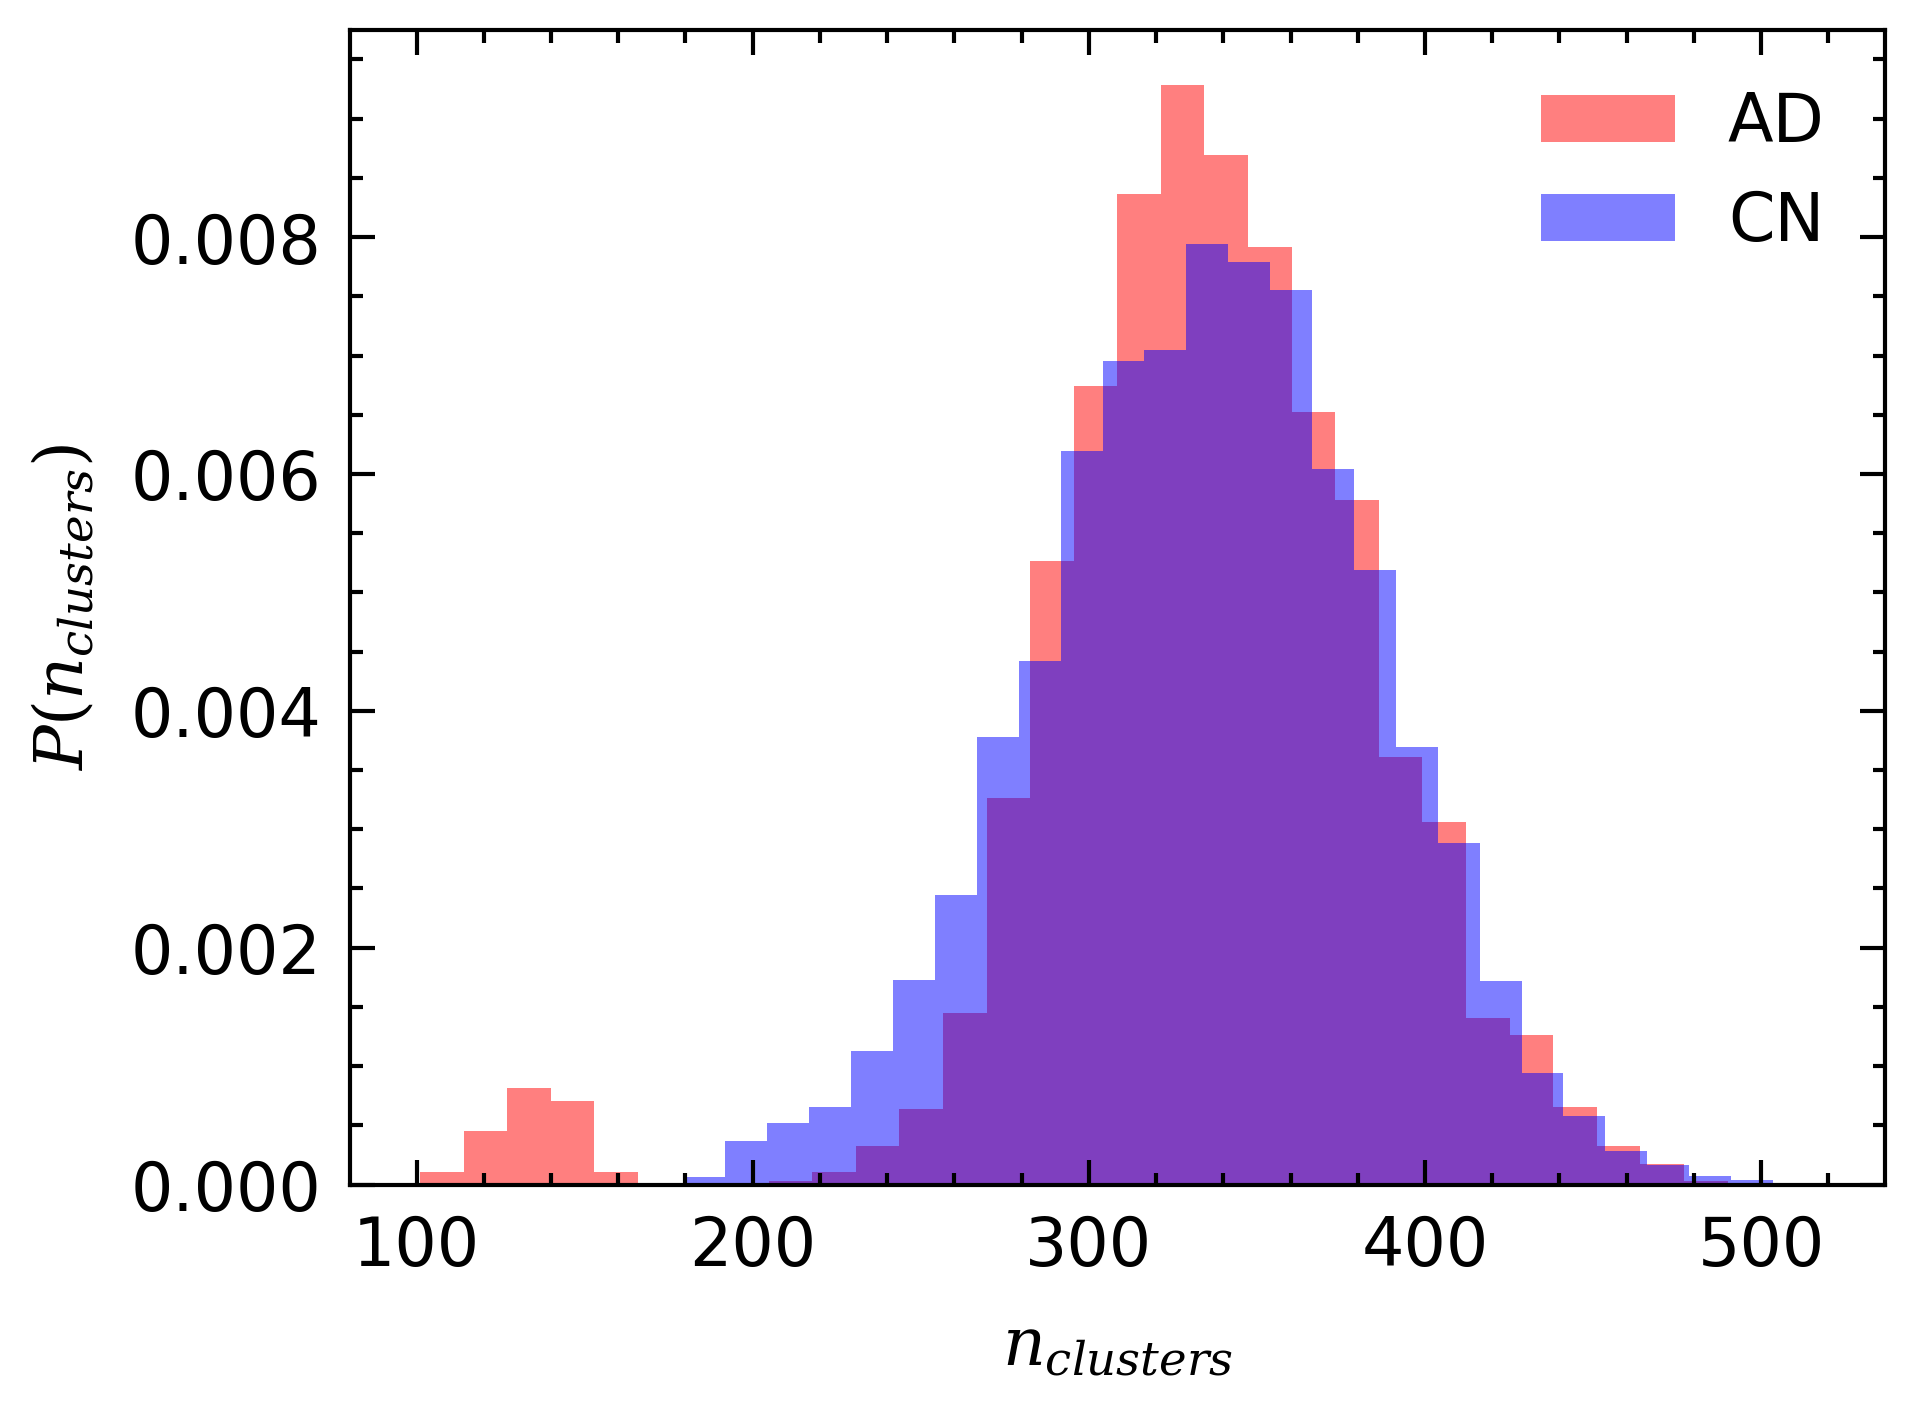

In [43]:
plt.hist(ad_n_clusts, label='AD', density=True, bins=30, alpha=0.5, color='red')
plt.hist(cn_n_clusts, label='CN', density=True, bins=30, alpha=0.5, color='blue')
plt.xlabel("$n_{clusters}$")
plt.ylabel("$P(n_{clusters})$")
plt.legend()

On sub 0
On sub 1
On sub 2
On sub 3
On sub 4
On sub 5
On sub 6
On sub 7
On sub 8
On sub 9
On sub 10
On sub 11
On sub 12
On sub 13
On sub 14
On sub 15
On sub 16
On sub 17
On sub 18
On sub 19
On sub 20
On sub 21
On sub 22
On sub 23
On sub 24
On sub 25
On sub 26
On sub 27
On sub 28
On sub 29
On sub 30
On sub 31
On sub 32
On sub 33
On sub 34
On sub 35
On sub 36
On sub 37
On sub 38
On sub 39
On sub 40
On sub 41
On sub 42
On sub 43
On sub 44
On sub 45
On sub 46
On sub 47
On sub 48
On sub 49
On sub 50
On sub 51
On sub 52
On sub 53
On sub 54
On sub 55
On sub 56
On sub 57
On sub 58
On sub 59
On sub 60
On sub 61
On sub 62
On sub 63
On sub 64
On sub 65
On sub 66
On sub 67
On sub 68
On sub 69
On sub 70
On sub 71
On sub 72
On sub 73
On sub 74
On sub 75
On sub 76
On sub 77
On sub 78
On sub 79
On sub 80
On sub 81
On sub 82
On sub 83
On sub 84
On sub 85
On sub 86
On sub 87
On sub 88


Text(0, 0.5, '$P(n_{clusters})$')

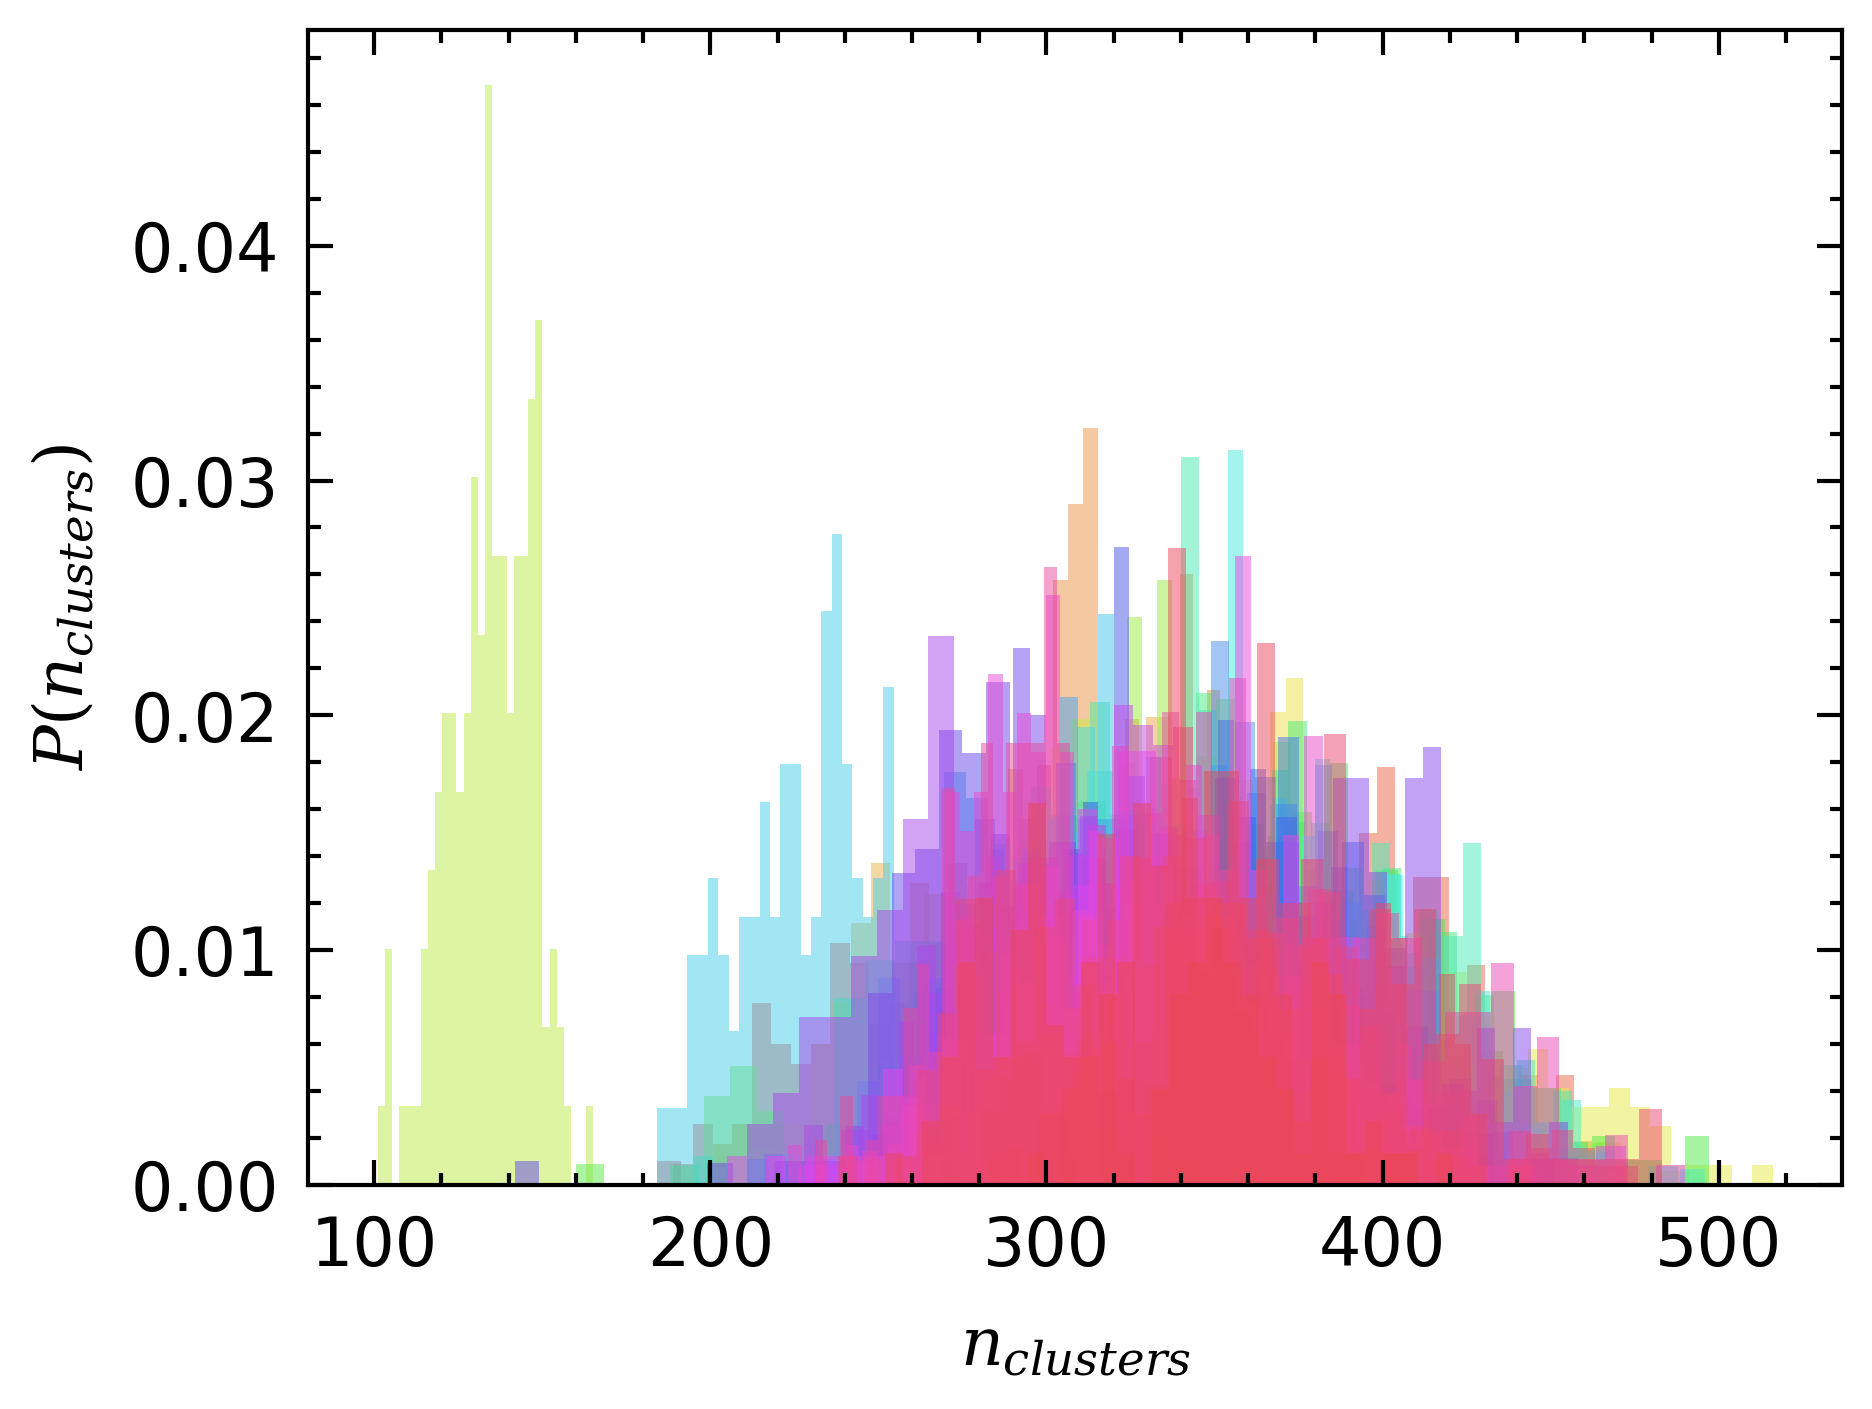

In [22]:
for i in range(len(dloader.subjects_list)):
    t_clusters = load_t_clusters(i)
    n_clusts = get_n_clusters(t_clusters)
    print(f"On sub {i}")
    
    c = 'red' if dloader.diag[i] else 'blue'
    plt.hist(n_clusts, density=True, bins=30, alpha=0.5, color=colors_array[i])
#     plt.hist(n_clusts, density=True, bins=30, label=dloader.diag[i], color=c, alpha=0.5)
plt.xlabel("$n_{clusters}$")
plt.ylabel("$P(n_{clusters})$")
# plt.legend()

In [112]:
def plot_n_clusts_vs_t(t_clusters):
    n_clusts = get_n_clusters(t_clusters)
    plt.plot(n_clusts)
    plt.xlabel("$t$")
    plt.ylabel("$n_{clusters}$")
    plt.show()
    
    plt.title("$n_{clusters}$ Probability Density for sub " + str(sub_idx))
    plt.hist(n_clusts, density=True, bins=30)
    plt.xlabel("$n_{clusters}$")
    plt.xlabel("$P(n_{clusters})$")
    plt.show()

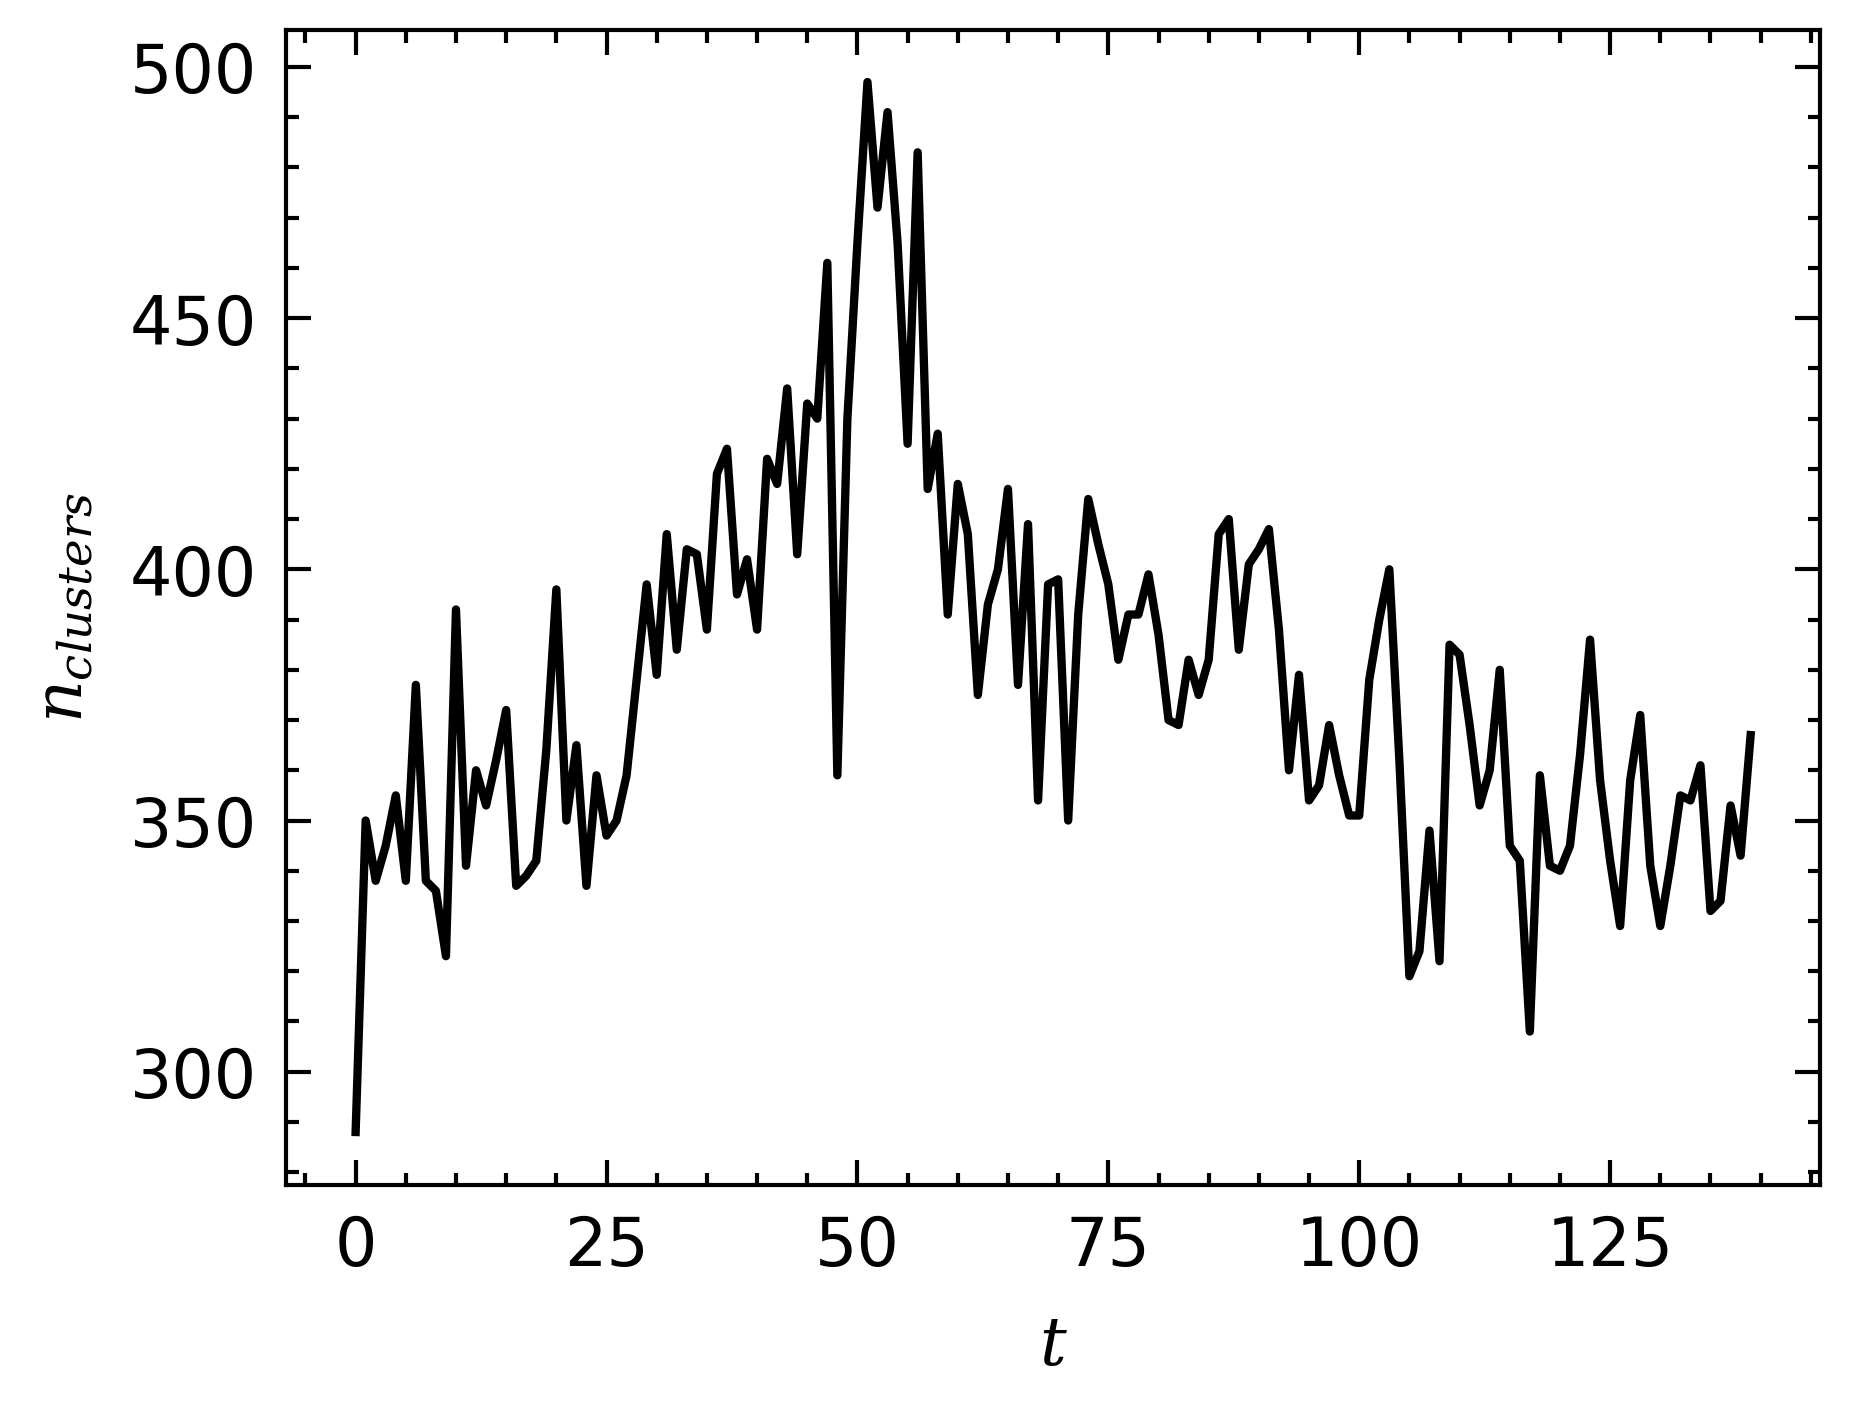

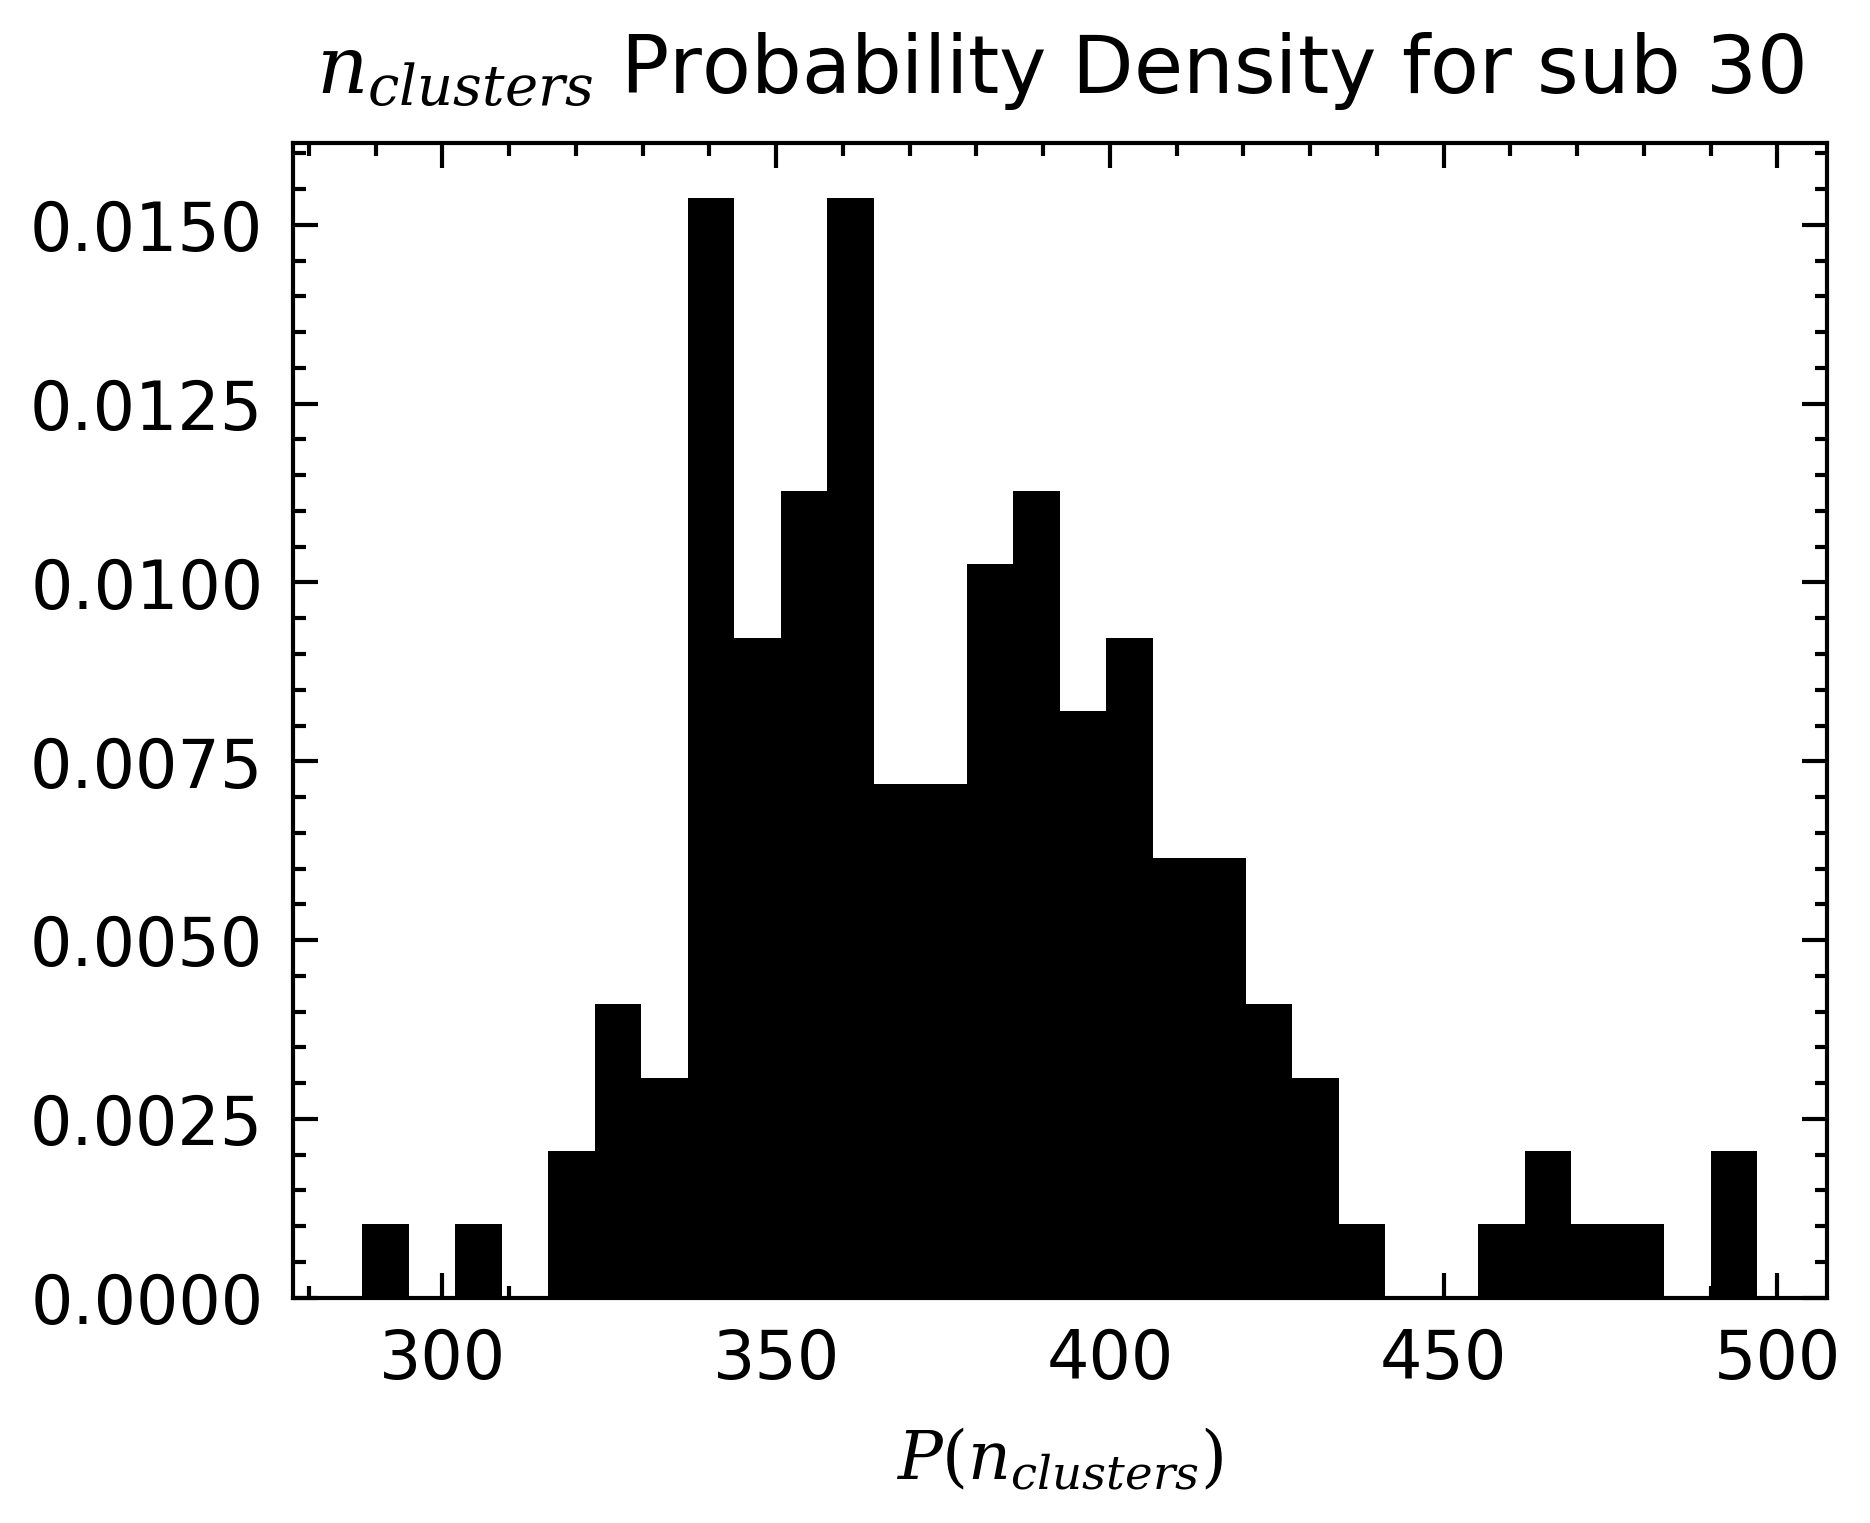

In [113]:
plot_n_clusts_vs_t(t_clusters)